# Домашнее задание 5
В этом задании мы:

1. Построим U-Net для датасета VOC segmentation, посмотрим на качество семантической сегментации.
2. Соберем GAN для генерации картинок из MNIST.
3. Прикрутим к этому GAN обуславливание на метку класса, посмотрим на результат.

## U-Net на датасете VOC

Датасет [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - один из классических датасетов для задачи семантической сегментации.
Его используют в статьях и [по сей день](https://paperswithcode.com/dataset/pascal-voc) для бенчмарков.

В этом задании вам нужно скачать этот датасет, разбить на train и validation части, и обучить на нем U-Net.
Код для U-Net разбирался в семинаре.

В ЛМС необходимо сдать вашу реализацию U-Net и `model.pt` файл обученной модели.
Чтобы сдать это задание, модель должна достигать accuracy > 50% на тестовом датасете.

In [1]:
import typing as tp
from functools import reduce
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from IPython.display import display
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.datasets import VOCSegmentation

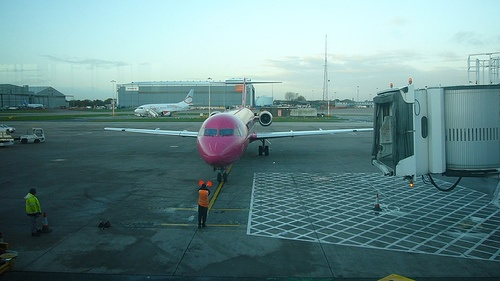

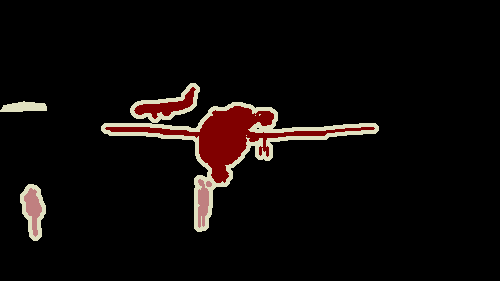

In [2]:
# Для начала загрузим датасет и посмотрим на его структуру
dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=not Path("./data").exists(),
)
display(dataset[0][0])
display(dataset[0][1])

В датасете маске присваивается 255 для границы объекта, а внутри объекта присваивается число от 0 до 20 - метка класса.

In [3]:
# Пройдемся по всем маскам датасета и возьмем уникальные значения в пикселях
reduce(
    lambda s1, s2: s1.union(s2),
    (set(np.unique(np.array(dataset[i][1])).tolist()) for i in range(len(dataset))),
    set(),
)
# Ага, действительно, метки классов от 0 до 20, при этом 0 означает "ничего интересного нет", а 255 означает границу

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}

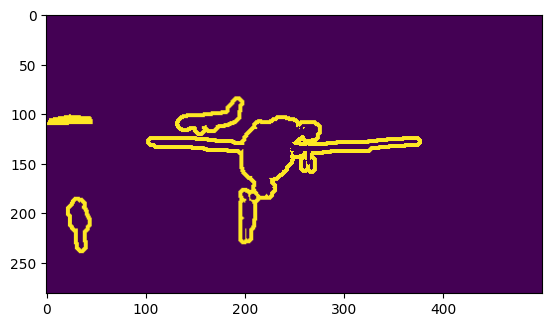

In [4]:
# Отрисуем только пиксели со значением 255 и убедимся, что они соответствуют границам объектов
plt.imshow(np.where(np.array(dataset[0][1]) == 255, 1, 0))

(tensor([[[0.5137, 0.5137, 0.5216,  ..., 0.7176, 0.7137, 0.7137],
         [0.5176, 0.5176, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         [0.5216, 0.5216, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.0392, 0.0314, 0.0431,  ..., 0.0235, 0.0353, 0.0314],
         [0.0235, 0.0196, 0.0353,  ..., 0.0549, 0.0588, 0.0627],
         [0.0196, 0.0353, 0.0431,  ..., 0.0667, 0.0588, 0.0667]],

        [[0.7569, 0.7569, 0.7647,  ..., 0.9137, 0.9098, 0.9098],
         [0.7608, 0.7608, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         [0.7647, 0.7647, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         ...,
         [0.0627, 0.0549, 0.0588,  ..., 0.0980, 0.1059, 0.1059],
         [0.0588, 0.0549, 0.0549,  ..., 0.1294, 0.1294, 0.1333],
         [0.0549, 0.0706, 0.0627,  ..., 0.1412, 0.1294, 0.1373]],

        [[0.8157, 0.8157, 0.8235,  ..., 0.9412, 0.9451, 0.9451],
         [0.8196, 0.8196, 0.8275,  ..., 0.9451, 0.9490, 0.9490],
         [0.8235, 0.8235, 0.8275,  ..., 0.9451, 0.9490, 0

C:\Users\Gulfik\Desktop\petprojects\kc-cv\dl_intro\.venv\Lib\site-packages\albumentations\augmentations\transforms.py:1803: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(
C:\Temp\ipykernel_2616\2771545398.py:59: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


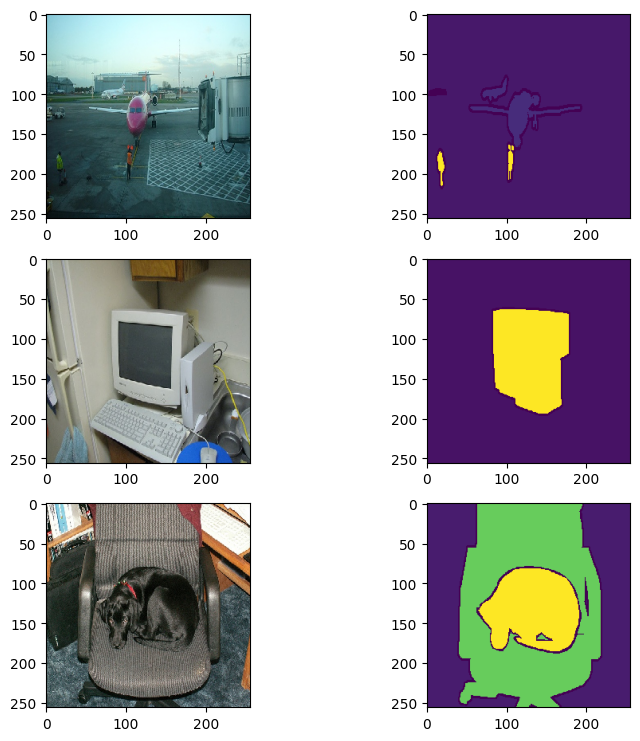

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
from pathlib import Path
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import typing as tp
import matplotlib.pyplot as plt

# Параметры
n_classes, img_size = 22, 256

def transform(image, mask):
    transforms = A.Compose(
        [
            A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST),
            A.Lambda(
                # Нормализуем изображение в отрезок [0, 1]
                image=lambda image, **_: image / 255.0,
                # Заменяем 255 на -1, чтобы игнорировать границы
                mask=lambda mask, **_: np.where(mask == 255, -1, mask),
            ),
            ToTensorV2(),
        ]
    )
    # Конвертируем из PIL формата в np.array
    transformed = transforms(image=np.array(image), mask=np.array(mask))
    return transformed["image"], transformed["mask"]

# Функция для загрузки датасета
def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    # Создание датасета с нужными трансформациями
    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=transform,
    )
    return dataset

# Загрузка данных
train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")

# Проверка данных
print(train_dataset[0])
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

# Отрисовка изображения и маски
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i in range(3):
    img, mask = train_dataset[i]
    ax[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax[i][1].imshow(mask.numpy())
fig.show()


In [6]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=-1)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=-1)

Теперь очередь за вами.
Обучите модель и сдайте её в ЛМС (инструкции выше).

Обратите внимание, что границы объекта выделены пикселем 255 - это немного выбивается из остальных классов, где метки идут с шагом 1 (0, 1, 2 и т.д. до 21).
Подумайте, как это исправить.

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Функция для обучения модели
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Игнорируем класс -1

    for epoch in range(epochs):
        print('Starting epoch {}/{}'.format(epoch + 1, epochs))
        model.train()
        print('Training...')
        total_loss = 0
        for img, mask in train_loader:
            img, mask = img.to(device).float(), mask.to(device).long()
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, mask)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

    torch.save(model.state_dict(), "unet_voc.pt")
    print("Модель сохранена как unet_voc.pt")


In [14]:
model = UNet(n_classes=n_classes)
train_model(model, train_loader, val_loader, epochs=20, learning_rate=1e-3)

Starting epoch 1/20
Training...
Epoch 1/20, Loss: 1.4433757496661828
Starting epoch 2/20
Training...
Epoch 2/20, Loss: 1.3165992342057775
Starting epoch 3/20
Training...
Epoch 3/20, Loss: 1.3178146435914795
Starting epoch 4/20
Training...
Epoch 4/20, Loss: 1.295734682044045
Starting epoch 5/20
Training...
Epoch 5/20, Loss: 1.2794105609258015
Starting epoch 6/20
Training...
Epoch 6/20, Loss: 1.2691977724351517
Starting epoch 7/20
Training...
Epoch 7/20, Loss: 1.2524597517779616
Starting epoch 8/20
Training...
Epoch 8/20, Loss: 1.2474056918764376
Starting epoch 9/20
Training...
Epoch 9/20, Loss: 1.2346785172738663
Starting epoch 10/20
Training...
Epoch 10/20, Loss: 1.2260681749041615
Starting epoch 11/20
Training...
Epoch 11/20, Loss: 1.2263994252746875
Starting epoch 12/20
Training...
Epoch 12/20, Loss: 1.2191562193338987
Starting epoch 13/20
Training...
Epoch 13/20, Loss: 1.226557706548868
Starting epoch 14/20
Training...
Epoch 14/20, Loss: 1.2212048554029622
Starting epoch 15/20
Train

In [15]:
test_dataset = load_voc_dataset("test")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

ValueError: Unknown value 'test' for argument image_set. Valid values are {'train', 'trainval', 'val'}.

In [ ]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Переводим модель в режим оценки

    correct = 0
    total = 0

    with torch.no_grad():  # Отключаем вычисление градиентов
        for img, mask in test_loader:
            img, mask = img.to(device).float(), mask.to(device).long()
            output = model(img)
            _, predicted = torch.max(output, 1)  # Получаем предсказанные классы
            correct += (predicted == mask).sum().item()  # Считаем правильные предсказания
            total += mask.numel()  # Общее количество пикселей

    accuracy = correct / total
    return accuracy

In [ ]:
accuracy = evaluate_model(model, test_loader)
print(f"Accuracy на тестовом датасете: {accuracy * 100:.2f}%")

# Correct solution

In [ ]:
def plot_accuracy(epoch: int, values: list[float]):
    """Пример:

    >>> acc.append(validation_accuracy)
    >>> plot(i + 1, validation_accuracy)
    """
    clear_output(True)
    plt.title("Epoch %s. Accuracy: %s" % (epoch, values[-1]))
    plt.plot(range(1, epoch + 1), values)
    plt.scatter(range(1, epoch + 1), values)
    plt.grid()
    plt.show()


def calc_accuracy(model: nn.Module, loader: DataLoader, device: torch.device):
    count_correct, count_total = 0, 0
    model.eval()
    for img_batch, mask_batch in tqdm.tqdm(loader):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        with torch.no_grad():
            prediction = model(img_batch)
            pred_labels = torch.argmax(prediction, dim=1)
            count_correct += (pred_labels == mask_batch).sum().item()
            count_total += reduce(lambda a, b: a * b, mask_batch.shape, 1)
    model.train()
    return count_correct / count_total


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device | str = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),
):
    model = model.to(device)
    val_acc = []
    for i in range(n_epochs):
        model.train()
        for img_batch, mask_batch in tqdm.tqdm(train_loader):
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            optimizer.zero_grad()
            outputs = model(img_batch)
            loss = F.cross_entropy(outputs, mask_batch.long())
            loss.backward()
            optimizer.step()
        val_acc.append(calc_accuracy(model, val_loader, device))
        plot_accuracy(i + 1, val_acc)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x: torch.Tensor, x_left: torch.Tensor):
        x = self.up(x)
        diffY = x_left.shape[2] - x.shape[2]
        diffX = x_left.shape[3] - x.shape[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x_left, x], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
model = UNet(3, n_classes)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
optimizer = Adam(model.parameters(), lr=1e-3)
# После трех эпох начинает переобучаться
train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    n_epochs=3,
    device="cuda",
)

torch.save(model.state_dict(), "model.pt")

## GAN на MNIST

Во второй части задания мы попробуем генерировать изображения с цифрами.
Для этого возьмем модель GAN и обучим ее на датасет MNIST.

Ваша задача: скачайте датасет MNIST, обучите на нем GAN, сохраните веса генератора и дискриминатора в `generator.pt` и `discriminator.pt` соответственно.
Сдайте в ЛМС:
1. Код генератора и его веса.
2. Код дискриминатора и его веса.

In [16]:
# Используйте следующие параметры модели
image_size = 28
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Параметры
image_size = 28
nz = 100  # Размер латентного вектора
batch_size = 128
epochs = 20
lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка датасета MNIST
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация к диапазону [-1, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh()  # Выход в диапазоне [-1, 1]
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, image_size, image_size)

# Дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size * image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Выход в диапазоне [0, 1]
        )

    def forward(self, x):
        x = x.view(-1, image_size * image_size)
        return self.main(x)

# Инициализация моделей
generator = Generator(nz, image_size).to(device)
discriminator = Discriminator(image_size).to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Функция потерь
criterion = nn.BCELoss()

# Обучение
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Обучение дискриминатора на реальных изображениях
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)

        # Обучение дискриминатора на фейковых изображениях
        z = torch.randn(batch_size, nz).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Общий loss для дискриминатора
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Логирование
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], "
                  f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

# Сохранение весов
torch.save(generator.state_dict(), "generator.pt")
torch.save(discriminator.state_dict(), "discriminator.pt")
print("Веса сохранены в generator.pt и discriminator.pt")

100%|██████████| 9.91M/9.91M [00:12<00:00, 775kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 207kB/s]
100%|██████████| 1.65M/1.65M [00:08<00:00, 195kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


Epoch [1/50], Step [0/469], d_loss: 1.3816, g_loss: 0.6908
Epoch [1/50], Step [100/469], d_loss: 0.7044, g_loss: 2.0681
Epoch [1/50], Step [200/469], d_loss: 1.7161, g_loss: 2.6884
Epoch [1/50], Step [300/469], d_loss: 0.1969, g_loss: 10.2281
Epoch [1/50], Step [400/469], d_loss: 0.5057, g_loss: 3.6950
Epoch [2/50], Step [0/469], d_loss: 0.0454, g_loss: 6.7575
Epoch [2/50], Step [100/469], d_loss: 0.1746, g_loss: 5.1282
Epoch [2/50], Step [200/469], d_loss: 0.2808, g_loss: 12.1948
Epoch [2/50], Step [300/469], d_loss: 0.0645, g_loss: 11.0646
Epoch [2/50], Step [400/469], d_loss: 0.1538, g_loss: 5.9667
Epoch [3/50], Step [0/469], d_loss: 0.5086, g_loss: 3.0129
Epoch [3/50], Step [100/469], d_loss: 0.7300, g_loss: 3.7395
Epoch [3/50], Step [200/469], d_loss: 0.8524, g_loss: 5.2320
Epoch [3/50], Step [300/469], d_loss: 1.8677, g_loss: 1.2740
Epoch [3/50], Step [400/469], d_loss: 0.7826, g_loss: 2.5861
Epoch [4/50], Step [0/469], d_loss: 0.8449, g_loss: 2.9855
Epoch [4/50], Step [100/469],

# Correct solution

In [ ]:
batch_size = 512


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.main(z.view(-1, 100, 1, 1))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


def show_generated_images(generator, noise):
    with torch.no_grad():
        generator.eval()  # Переключить модель в режим оценки
        images = generator(noise).detach().cpu()  # Генерация изображений
        generator.train()  # Вернуть в режим обучения
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(make_grid(images, padding=2, normalize=True).permute(1, 2, 0))


def train_gan(
    generator: nn.Module, discriminator: nn.Module, train_loader: DataLoader, device
):
    generator.to(device)
    discriminator.to(device)
    optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(
        discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
    )

    criterion = nn.BCELoss()

    num_epochs = 10
    fixed_noise = torch.randn(64, nz, device=device)
    for epoch in range(1, num_epochs + 1):
        for i, (images, _) in enumerate(train_loader):
            b_size = images.size(0)
            real_data = images.to(device)
            label_real = torch.full((b_size,), 1, dtype=torch.float, device=device)
            label_fake = torch.full((b_size,), 0, dtype=torch.float, device=device)

            # Обучение дискриминатора
            discriminator.zero_grad()
            output_real = discriminator(real_data).view(-1)
            loss_real = criterion(output_real, label_real)
            loss_real.backward()

            noise = torch.randn(b_size, nz, device=device)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data.detach()).view(-1)
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()
            optimizerD.step()

            # Обучение генератора
            generator.zero_grad()
            output = discriminator(fake_data).view(-1)
            loss_G = criterion(output, label_real)
            loss_G.backward()
            optimizerG.step()

            if i % 50 == 0:
                clear_output(True)
                show_generated_images(generator, fixed_noise)
                plt.title("Epoch %s. Iteration %s." % (epoch, i))
                plt.show()


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

transforms = A.Compose(
    [
        # Это важно: необходимо нормировать на отрезок [-1, 1], так как в генераторе используется Tanh
        A.Normalize((0.5,), (0.5,), max_pixel_value=255.0),
        ToTensorV2(),
    ]
)
mnist_dataset = MNIST(
    "./data",
    train=True,
    download=True,
    transform=lambda image: transforms(image=np.array(image))["image"],
)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

generator = Generator()
discriminator = Discriminator()
generator.apply(weights_init)
discriminator.apply(weights_init)

train_gan(generator, discriminator, mnist_loader, device)
torch.save(generator.state_dict(), "generator.pt")
torch.save(discriminator.state_dict(), "discriminator.pt")

## GAN с условиями

Наш GAN генерирует картинку из случайного класса.
Однако можно научить его принимать на вход метку класса и генерировать картинку с этой меткой.
Такие GAN называются **Conditional GAN** (*обусловленный GAN*).

Добавить обуславливание достаточно просто:
1. Добавьте в генератор embedding-слой для метки класса. Берите небольшую размерность вектора, 10-ти хватит.
2. Поменяйте первый ConvTranspose2d так, чтобы тот принял вектор длины 110 (100 от рандома, 10 от эмбеддинга).
3. Поменяйте код `forward` так, чтобы в ConvTranspose2d передавать объединенный вектор размера 110.
4. Сделайте аналогичные изменения в `Discriminator` - он тоже должен принимать `label` как аргумент в `forward` и учитывать его. Подумайте, какие слои и как надо будет поменять.

Сделайте **Conditional GAN**, обучите его.
Сдайте в ЛМС:
1. Новый код `Generator` и его веса.
2. Новый код `Discriminator` и его веса.

In [20]:
epochs = 20

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 10)  # Embedding для метки класса
        self.main = nn.Sequential(
            # Входной размер: nz (100) + 10 (embedding) = 110
            nn.ConvTranspose2d(110, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        # Получаем embedding для метки класса
        label_embedding = self.label_embedding(labels)
        # Объединяем случайный шум и embedding
        x = torch.cat([z, label_embedding], dim=1)
        # Преобразуем в 4D-тензор (batch_size, 110, 1, 1)
        x = x.unsqueeze(2).unsqueeze(3)
        # Генерация изображения
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, 28 * 28)  # Embedding для метки класса
        self.main = nn.Sequential(
            # Входной размер: 1 (канал изображения) + 1 (embedding) = 2
            nn.Conv2d(2, 64, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, input, labels):
        # Получаем embedding для метки класса
        label_embedding = self.label_embedding(labels)
        # Преобразуем embedding в 4D-тензор (batch_size, 1, 28, 28)
        label_embedding = label_embedding.view(-1, 1, 28, 28)
        # Объединяем изображение и embedding
        x = torch.cat([input, label_embedding], dim=1)
        # Классификация
        return self.main(x)

nz = 100  # Размер латентного вектора
num_classes = 10  # Количество классов в MNIST

# Инициализация моделей
generator = Generator(nz, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)

# Оптимизаторы
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


for epoch in range(epochs):
    for i, (real_images, labels) in enumerate(train_loader):
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        # Метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Обучение дискриминатора на реальных изображениях
        optimizer_D.zero_grad()
        real_outputs = discriminator(real_images, labels)
        d_loss_real = criterion(real_outputs, real_labels)

        # Обучение дискриминатора на фейковых изображениях
        z = torch.randn(batch_size, nz).to(device)
        fake_images = generator(z, labels)
        fake_outputs = discriminator(fake_images.detach(), labels)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Общий loss для дискриминатора
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        fake_outputs = discriminator(fake_images, labels)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Логирование
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(train_loader)}], "
                  f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")


torch.save(generator.state_dict(), "generator_cgan.pt")
torch.save(discriminator.state_dict(), "discriminator_cgan.pt")

Epoch [1/20], Step [0/469], d_loss: 1.3949, g_loss: 0.8819
Epoch [1/20], Step [100/469], d_loss: 0.0132, g_loss: 5.2918
Epoch [1/20], Step [200/469], d_loss: 0.0030, g_loss: 6.4385
Epoch [1/20], Step [300/469], d_loss: 0.0010, g_loss: 7.5289
Epoch [1/20], Step [400/469], d_loss: 0.0008, g_loss: 8.0838
Epoch [2/20], Step [0/469], d_loss: 0.0004, g_loss: 8.3570
Epoch [2/20], Step [100/469], d_loss: 0.0004, g_loss: 8.8102
Epoch [2/20], Step [200/469], d_loss: 0.0002, g_loss: 9.0600
Epoch [2/20], Step [300/469], d_loss: 0.0002, g_loss: 9.2600
Epoch [2/20], Step [400/469], d_loss: 0.0001, g_loss: 9.5001
Epoch [3/20], Step [0/469], d_loss: 0.0001, g_loss: 9.6691
Epoch [3/20], Step [100/469], d_loss: 0.0001, g_loss: 9.9071
Epoch [3/20], Step [200/469], d_loss: 0.0001, g_loss: 9.9852
Epoch [3/20], Step [300/469], d_loss: 0.0001, g_loss: 10.2090
Epoch [3/20], Step [400/469], d_loss: 0.0000, g_loss: 10.4222
Epoch [4/20], Step [0/469], d_loss: 0.0000, g_loss: 10.4330
Epoch [4/20], Step [100/469],

Если вы все сделали правильно, у вас должны получиться правдоподобные картинки для каждого из классов.

# Correct solution

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.main = nn.Sequential(
            # Вход: Z_dim + label_dim -> 100 + 10 = 110
            # Размер: [batch, 110, 1, 1]
            nn.ConvTranspose2d(110, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Размер: [batch, 256, 7, 7]
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Размер: [batch, 128, 14, 14]
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Размер: [batch, 64, 28, 28]
            nn.ConvTranspose2d(64, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
            # Размер: [batch, 1, 28, 28]
        )

    def forward(self, z, labels):
        z = z.view(-1, 100, 1, 1)
        c = self.label_emb(labels).view(-1, 10, 1, 1)
        x = torch.cat([z, c], 1)
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(10, 10)
        self.main = nn.Sequential(
            # Размер: [batch, 1 + 10, 28, 28]
            nn.Conv2d(1 + 10, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # Размер: [batch, 64, 14, 14]
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Размер: [batch, 128, 7, 7]
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Размер: [batch, 256, 4, 4]
            nn.Conv2d(256, 1, 4, 1, 0),
            # Размер: [batch, 1, 1, 1]
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 1, 28, 28)
        c = self.label_emb(labels).view(-1, 10, 1, 1).expand(-1, -1, 28, 28)
        x = torch.cat([x, c], 1)  # конкатенация по каналам
        return self.main(x).view(-1)


def show_conditional_generated_images(generator, noise, labels):
    with torch.no_grad():
        generator.eval()
        images = generator(noise, labels).detach().cpu()  # <<<
        generator.train()
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(make_grid(images, padding=2, nrow=10, normalize=True).permute(1, 2, 0))


def train_conditional_gan(
    generator: nn.Module, discriminator: nn.Module, train_loader: DataLoader, device
):
    # То же самое, что в прошлом пункте, но теперь передаем метки классов
    generator.to(device)
    discriminator.to(device)
    optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(
        discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
    )

    criterion = nn.BCELoss()

    num_epochs = 20
    fixed_noise = torch.randn(100, nz, device=device)
    fixed_labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).to(
        device
    )
    for epoch in range(1, num_epochs + 1):
        for i, (images, labels) in enumerate(train_loader):  # <<<
            b_size = images.size(0)
            real_labels = labels.to(device)  # <<<
            real_data = images.to(device)
            label_real = torch.full((b_size,), 1, dtype=torch.float, device=device)
            label_fake = torch.full((b_size,), 0, dtype=torch.float, device=device)

            # Обучение дискриминатора
            discriminator.zero_grad()
            output_real = discriminator(real_data, real_labels).view(-1)  # <<<
            loss_real = criterion(output_real, label_real)
            loss_real.backward()

            noise = torch.randn(b_size, nz, device=device)
            fake_labels = torch.randint(
                0, 10, (b_size,), device=device
            )  # Случайные метки для фальшивых данных
            fake_data = generator(noise, fake_labels)  # <<<
            output_fake = discriminator(fake_data.detach(), fake_labels).view(-1)  # <<<
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()
            optimizerD.step()

            # Обучение генератора
            generator.zero_grad()
            output = discriminator(fake_data, fake_labels).view(-1)  # <<<
            loss_G = criterion(output, label_real)
            loss_G.backward()
            optimizerG.step()

            if i % 50 == 0:
                clear_output(True)
                show_conditional_generated_images(generator, fixed_noise, fixed_labels)
                plt.title("Epoch %s. Iteration %s." % (epoch, i))
                plt.show()


torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

conditional_generator = Generator()
conditional_discriminator = Discriminator()
conditional_generator.apply(weights_init)
conditional_discriminator.apply(weights_init)

train_conditional_gan(
    conditional_generator, conditional_discriminator, mnist_loader, device
)
torch.save(conditional_generator.state_dict(), "conditional_generator.pt")
torch.save(conditional_discriminator.state_dict(), "conditional_discriminator.pt")